# DLBasics2023 最終課題
実行結果付き。
参考データ収集用.（Cosine Annealing 50回）
### 作者： tfujiwara
### 日付： 2023-Aug-02

## 課題
第11回「変分オートエンコーダ（VAE）を用いてFasionMNISTの画像を生成してみましょう」<br>
を発展させ、学習率探索プログラムを開発する

### 目標

課題の目標値は「NLL（負の対数尤度） 235」であったが、これにこだわらず、
自動探索により、良い検証結果の出る学習率が得られることとする。
以下の、オリジナル課題ルールは、あえて変更せず、**学習率とエポック数以外の条件を固定した中で、最良の検証結果を出す。**

### オリジナル課題ルール

- 訓練データは`x_train`，テストデータは`x_test`で与えられます．
- 下のセルで指定されている`x_train`以外の学習データは使わないでください．

### 評価方法

- 評価は生成画像の検証データに対するNLL（負の対数尤度）とした。<br>（オリジナル課題は、テストデータに対するNLL）

\begin{equation}
-\sum_{i=1}^Dx_i\log\hat{x_i}+(1-x_i)\log(1-\hat{x_i})
\end{equation}

### ドライブのマウント

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### データの読み込み（このセルは修正しないでください）

In [ ]:
import numpy as np
import pandas as pd
import torch

seed = 1234
torch.manual_seed(seed)
np.random.seed(seed)

# 学習データ
x_train = np.load('drive/MyDrive/Colab Notebooks/DLBasics2023_colab/FinalProj/data/x_train.npy')
# テストデータ
x_test = np.load('drive/MyDrive/Colab Notebooks/DLBasics2023_colab/FinalProj/data/x_test.npy')


class dataset(torch.utils.data.Dataset):
    def __init__(self, x_test):
        self.x_test = x_test.reshape(-1, 784).astype('float32') / 255

    def __len__(self):
        return self.x_test.shape[0]

    def __getitem__(self, idx):
        return torch.tensor(self.x_test[idx], dtype=torch.float)

trainval_data = dataset(x_train)
test_data = dataset(x_test)

### VAEの実装


In [ ]:
batch_size = 32

val_size = 10000
train_size = len(trainval_data) - val_size

train_data, val_data = torch.utils.data.random_split(trainval_data, [train_size, val_size])

dataloader_train = torch.utils.data.DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True
)

dataloader_valid = torch.utils.data.DataLoader(
    val_data,
    batch_size=batch_size,
    shuffle=True
)

dataloader_test = torch.utils.data.DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=False
)

In [ ]:
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F
from typing import Tuple

device = "cuda" if torch.cuda.is_available() else "cpu"


# torch.log(0)によるnanを防ぐ
def torch_log(x):
    return torch.log(torch.clamp(x, min=1e-10))

# VAEモデルの実装
class VAE(nn.Module):
    # WRITE ME
    def __init__(self, z_dim: int) -> None:
        super().__init__()

        # Encoder, xを入力にガウス分布のパラメータmu, sigmaを出力
        self.dense_enc1 = nn.Linear(28*28, 200)
        self.dense_enc2 = nn.Linear(200, 200)
        self.dense_encmean = nn.Linear(200, z_dim)
        self.dense_encvar = nn.Linear(200, z_dim)

        # Decoder, zを入力にベルヌーイ分布のパラメータlambdaを出力
        self.dense_dec1 = nn.Linear(z_dim, 200)
        self.dense_dec2 = nn.Linear(200, 200)
        self.dense_dec3 = nn.Linear(200, 28*28)

    def _encoder(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        x = F.relu(self.dense_enc1(x))
        x = F.relu(self.dense_enc2(x))
        mean = self.dense_encmean(x)
        std = F.softplus(self.dense_encvar(x))

        return mean, std

    def _sample_z(self, mean: torch.Tensor, std: torch.Tensor) -> torch.Tensor:
        if self.training:
            # 再パラメータ化トリック．この乱数は計算グラフで勾配の通り道に無い．
            epsilon = torch.randn(mean.shape).to(device)
            return mean + std * epsilon
        else:
            return mean

    def _decoder(self, z: torch.Tensor) -> torch.Tensor:
        x = F.relu(self.dense_dec1(z))
        x = F.relu(self.dense_dec2(x))
        # 出力が0~1になるようにsigmoid
        x = torch.sigmoid(self.dense_dec3(x))

        return x

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        mean, std = self._encoder(x)
        z = self._sample_z(mean, std)
        x = self._decoder(z)
        return x, z

    def loss(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        mean, std = self._encoder(x)

        # KL loss(正則化項)の計算. mean, stdは (batch_size , z_dim)
        # torch.sumは上式のJ(=z_dim)に関するもの. torch.meanはbatch_sizeに関するものなので,
        # 上式には書いてありません.
        KL = -0.5 * torch.mean(torch.sum(1 + torch_log(std**2) - mean**2 - std**2, dim=1))

        z = self._sample_z(mean, std)
        y = self._decoder(z)

        # reconstruction loss(負の再構成誤差)の計算. x, yともに (batch_size , 784)
        # torch.sumは上式のD(=784)に関するもの. torch.meanはbatch_sizeに関するもの.
        reconstruction = torch.mean(torch.sum(x * torch_log(y) + (1 - x) * torch_log(1 - y), dim=1))

        return KL, -reconstruction

自分の関数の追加

In [ ]:
import datetime
import pytz
import math
timezone = 'Europe/Budapest'

def datetime_now():
    new_timezone = pytz.timezone(timezone)
    return datetime.datetime.now().astimezone(new_timezone)

class XPrint:
    ### 画面と同じものを記録する。
    def __init__(self, filename, mystr):
        self.filename = filename
        if ( mystr != "" ):
            self.message_time(mystr)
    def __call__(self, mystr):
        self.message("{} {}".format(datetime_now().strftime("%Y/%m/%d %H:%M:%S"), mystr))
    def message(self, mystr):
        try:
            with open(self.filename, "a") as f:
                f.write("{}\n".format(mystr))
        except FileNotFoundError:
            print("* "+mystr)
            return
        print("  "+mystr)
    def message_time(self, mystr):
        self.message("{} {}".format(datetime_now().strftime("%Y/%m/%d %H:%M:%S"), mystr))
xprint = XPrint('drive/MyDrive/Colab Notebooks/DLBasics2023_colab/FinalProj/xprint{}.txt'.format(datetime_now().strftime("%Y%m%d")), "")

class CosineScheduler:
    def __init__(self, epochs, lr, warmup_length=5):
        """
        Arguments
        ---------
        epochs : int
            学習のエポック数．
        lr : float
            学習率．
        warmup_length : int
            warmupを適用するエポック数．
        """
        self.epochs = epochs
        self.lr = lr
        self.warmup = warmup_length

    def __call__(self, epoch):
        """
        Arguments
        ---------
        epoch : int
            現在のエポック数．
        """
        progress = (epoch - self.warmup) / (self.epochs - self.warmup)
        progress = np.clip(progress, 0.0, 1.0)
        lr = self.lr * 0.5 * (1. + np.cos(np.pi * progress))

        if self.warmup:
            lr = lr * min(1., (epoch+1) / self.warmup)
        return lr

  2023/07/29 20:43:45 EPOCH:1, Train Lower Bound:299.617920, (9.382020, 290.235901), Valid Lower Bound:261.883209 lr=0.00020000 最小値更新
  2023/07/29 20:43:59 EPOCH:2, Train Lower Bound:257.786194, (11.238808, 246.547394), Valid Lower Bound:251.014084 lr=0.00040000 最小値更新
  2023/07/29 20:44:12 EPOCH:3, Train Lower Bound:250.614746, (11.642273, 238.972458), Valid Lower Bound:244.678635 lr=0.00060000 最小値更新
  2023/07/29 20:44:25 EPOCH:4, Train Lower Bound:247.293930, (12.017821, 235.276108), Valid Lower Bound:242.940598 lr=0.00080000 最小値更新
  2023/07/29 20:44:38 EPOCH:5, Train Lower Bound:245.376816, (12.251584, 233.125229), Valid Lower Bound:241.801300 lr=0.00100000 最小値更新
  2023/07/29 20:44:51 EPOCH:6, Train Lower Bound:243.792374, (12.467814, 231.324570), Valid Lower Bound:239.729675 lr=0.00100000 最小値更新
  2023/07/29 20:45:05 EPOCH:7, Train Lower Bound:242.804932, (12.577946, 230.226974), Valid Lower Bound:239.654282 lr=0.00099878 最小値更新
  2023/07/29 20:45:19 EPOCH:8, Train Lower Bound:242.118

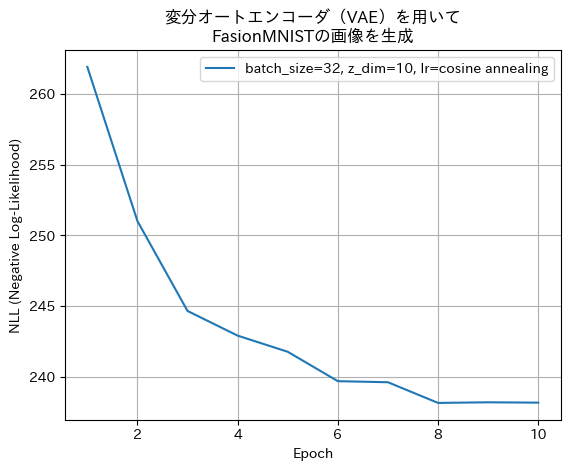

  2023/07/29 20:46:02 EPOCH:11, Train Lower Bound:240.676147, (12.762408, 227.913727), Valid Lower Bound:237.688248 lr=0.00096985 最小値更新
  2023/07/29 20:46:22 EPOCH:12, Train Lower Bound:240.413651, (12.783824, 227.629837), Valid Lower Bound:237.443970 lr=0.00095677 最小値更新
  2023/07/29 20:46:38 EPOCH:13, Train Lower Bound:240.137573, (12.812011, 227.325546), Valid Lower Bound:236.901459 lr=0.00094147 最小値更新
  2023/07/29 20:46:53 EPOCH:14, Train Lower Bound:239.882507, (12.846409, 227.036087), Valid Lower Bound:236.625626 lr=0.00092402 最小値更新
  2023/07/29 20:47:08 EPOCH:15, Train Lower Bound:239.648712, (12.845471, 226.803238), Valid Lower Bound:236.888870 lr=0.00090451 
  2023/07/29 20:47:23 EPOCH:16, Train Lower Bound:239.451172, (12.864381, 226.586792), Valid Lower Bound:236.662842 lr=0.00088302 
  2023/07/29 20:47:38 EPOCH:17, Train Lower Bound:239.262238, (12.864637, 226.397598), Valid Lower Bound:236.797150 lr=0.00085967 
  2023/07/29 20:47:55 EPOCH:18, Train Lower Bound:239.096924, (

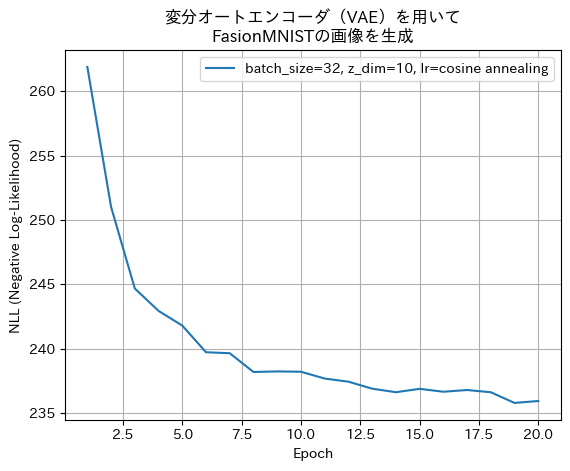

  2023/07/29 20:48:42 EPOCH:21, Train Lower Bound:238.577240, (12.938531, 225.638702), Valid Lower Bound:235.860352 lr=0.00075000 
  2023/07/29 20:48:57 EPOCH:22, Train Lower Bound:238.409897, (12.947521, 225.462387), Valid Lower Bound:235.762436 lr=0.00071919 最小値更新
  2023/07/29 20:49:13 EPOCH:23, Train Lower Bound:238.273575, (12.947762, 225.325806), Valid Lower Bound:235.625153 lr=0.00068730 最小値更新
  2023/07/29 20:49:28 EPOCH:24, Train Lower Bound:238.095444, (12.956435, 225.139038), Valid Lower Bound:235.399918 lr=0.00065451 最小値更新
  2023/07/29 20:49:42 EPOCH:25, Train Lower Bound:237.974686, (12.982298, 224.992355), Valid Lower Bound:235.451172 lr=0.00062096 
  2023/07/29 20:49:57 EPOCH:26, Train Lower Bound:237.825867, (12.984982, 224.840897), Valid Lower Bound:235.333221 lr=0.00058682 最小値更新
  2023/07/29 20:50:12 EPOCH:27, Train Lower Bound:237.682861, (12.997950, 224.684937), Valid Lower Bound:235.146561 lr=0.00055226 最小値更新
  2023/07/29 20:50:26 EPOCH:28, Train Lower Bound:237.5718

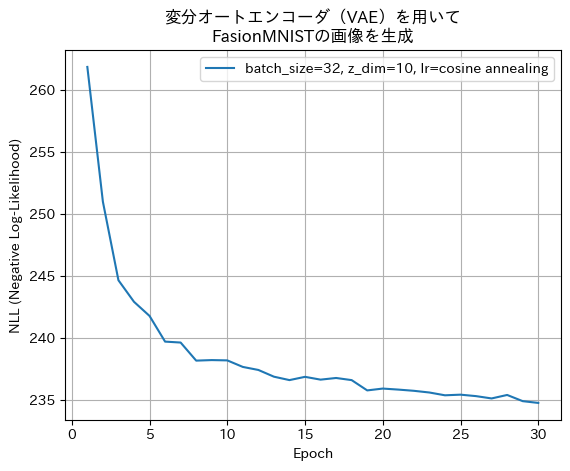

  2023/07/29 20:51:09 EPOCH:31, Train Lower Bound:237.199677, (13.048390, 224.151276), Valid Lower Bound:234.834412 lr=0.00041318 
  2023/07/29 20:51:23 EPOCH:32, Train Lower Bound:237.051620, (13.037178, 224.014435), Valid Lower Bound:234.639572 lr=0.00037904 最小値更新
  2023/07/29 20:51:37 EPOCH:33, Train Lower Bound:236.959763, (13.054118, 223.905640), Valid Lower Bound:234.548279 lr=0.00034549 最小値更新
  2023/07/29 20:51:52 EPOCH:34, Train Lower Bound:236.870789, (13.076330, 223.794479), Valid Lower Bound:234.543457 lr=0.00031270 最小値更新
  2023/07/29 20:52:06 EPOCH:35, Train Lower Bound:236.773056, (13.095453, 223.677597), Valid Lower Bound:234.666061 lr=0.00028081 
  2023/07/29 20:52:21 EPOCH:36, Train Lower Bound:236.633911, (13.068197, 223.565689), Valid Lower Bound:234.190002 lr=0.00025000 最小値更新
  2023/07/29 20:52:35 EPOCH:37, Train Lower Bound:236.562164, (13.099149, 223.463013), Valid Lower Bound:234.307983 lr=0.00022040 
  2023/07/29 20:52:51 EPOCH:38, Train Lower Bound:236.480713, (

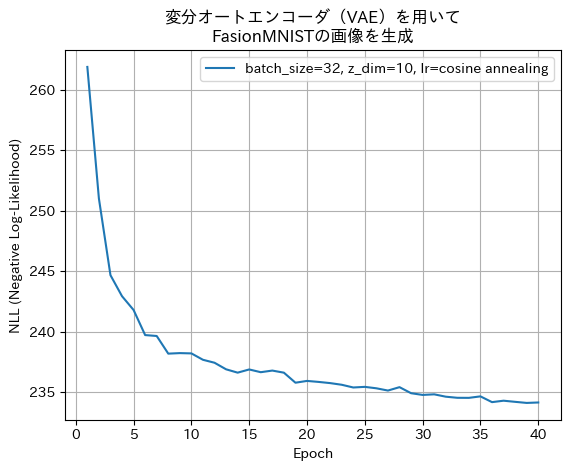

  2023/07/29 20:53:37 EPOCH:41, Train Lower Bound:236.247299, (13.121637, 223.125671), Valid Lower Bound:234.050888 lr=0.00011698 最小値更新
  2023/07/29 20:53:51 EPOCH:42, Train Lower Bound:236.170685, (13.122966, 223.047729), Valid Lower Bound:233.885727 lr=0.00009549 最小値更新
  2023/07/29 20:54:06 EPOCH:43, Train Lower Bound:236.128571, (13.126708, 223.001862), Valid Lower Bound:234.012131 lr=0.00007598 
  2023/07/29 20:54:20 EPOCH:44, Train Lower Bound:236.073532, (13.121331, 222.952209), Valid Lower Bound:233.938126 lr=0.00005853 
  2023/07/29 20:54:34 EPOCH:45, Train Lower Bound:236.044205, (13.143077, 222.901108), Valid Lower Bound:233.813400 lr=0.00004323 最小値更新
  2023/07/29 20:54:49 EPOCH:46, Train Lower Bound:235.992233, (13.140356, 222.851883), Valid Lower Bound:233.880447 lr=0.00003015 
  2023/07/29 20:55:03 EPOCH:47, Train Lower Bound:235.938705, (13.122470, 222.816238), Valid Lower Bound:233.747879 lr=0.00001937 最小値更新
  2023/07/29 20:55:18 EPOCH:48, Train Lower Bound:235.923965, (

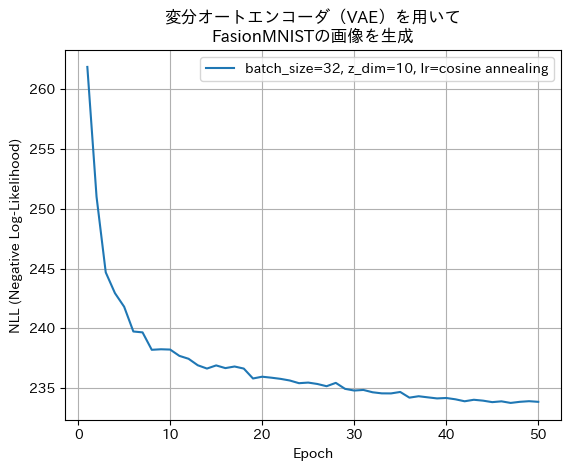

In [ ]:
z_dim = 10
assert z_dim >= 2
n_epochs = 50
lr=0.001     #0.00151 #0.001
scheduler = CosineScheduler(epochs=n_epochs, lr=lr)

model = VAE(z_dim).to(device)
#optimizer = optim.Adam(model.parameters(), lr=lr) #0.001
!pip install japanize_matplotlib >nul
import matplotlib.pyplot as plt
import japanize_matplotlib
plt.clf()
gx = []
gy = []
title_font = {
    'color':  'black',
    'weight': 'bold',
    'size': 12,
}

min_valid_lower_bound = 9999                                                    # 最小値の初期値
for epoch in range(n_epochs):
    lr = scheduler(epoch)
    optimizer = optim.Adam(model.parameters(), lr=lr) #0.001


    losses = []
    KL_losses = []
    reconstruction_losses = []
    model.train()
    for x in dataloader_train:

        # WRITE ME
        x = x.to(device)
        model.zero_grad()
        # KL_loss, reconstruction_lossの各項の計算
        KL_loss, reconstruction_loss = model.loss(x)
        # エビデンス下界の最大化のためマイナス付きの各項の値を最小化するようにパラメータを更新
        loss = KL_loss + reconstruction_loss
        loss.backward()
        optimizer.step()

        losses.append(loss.cpu().detach().numpy())
        KL_losses.append(KL_loss.cpu().detach().numpy())
        reconstruction_losses.append(reconstruction_loss.cpu().detach().numpy())

    losses_val = []
    model.eval()
    for x in dataloader_valid:

        # WRITE ME
        x = x.to(device)
        KL_loss, reconstruction_loss = model.loss(x)
        loss = KL_loss + reconstruction_loss

        losses_val.append(loss.cpu().detach().numpy())
    valid_lower_bound = np.average(losses_val)
    if valid_lower_bound < min_valid_lower_bound:
        min_valid_lower_bound = valid_lower_bound
        msg = "最小値更新"
    else:
        msg = ""
    xprint('EPOCH:%d, Train Lower Bound:%lf, (%lf, %lf), Valid Lower Bound:%lf lr=%.8lf %s' %
          (epoch+1, np.average(losses), np.average(KL_losses), np.average(reconstruction_losses), np.average(losses_val), lr, msg))
    gx.append(epoch+1)
    gy.append(np.average(losses_val))
    if (epoch+1) % 10 == 0:
        plt.plot(gx, gy, label=f'batch_size={batch_size}, z_dim={z_dim}, lr=cosine annealing')
        plt.xlabel(f"Epoch")                                     # グラフ表示用
        plt.ylabel(f"NLL (Negative Log-Likelihood)")                             # グラフ表示用
        plt.grid(True)
        plt.legend()
        plt.title(f"変分オートエンコーダ（VAE）を用いて\nFasionMNISTの画像を生成", fontdict=title_font)
        plt.show()

In [ ]:
import csv

sample_x = []
answer = []
model.eval()
for x in dataloader_test:
    x = x.to(device)
    y, _ = model(x)
    y = y.tolist()
    sample_x.extend(y)

with open('drive/MyDrive/Colab Notebooks/DLBasics2023_colab/FinalProj/submission_pred.csv', 'w') as file:
    writer = csv.writer(file, lineterminator='\n')
    writer.writerows(sample_x)
file.close()